<a href="https://colab.research.google.com/github/mateusribeirocampos/diollm/blob/main/Image_recommendation_system_DIO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistema de recomandação por imagens

Projeto desenvolvido para o desafio da DIO sobre recomenadação por imagens. O modelo foi construído a partir do código de [exemplo](https://colab.research.google.com/github/sparsh-ai/rec-tutorials/blob/master/_notebooks/2021-04-27-image-similarity-recommendations.ipynb). O modelo utilizado foi [BiT collection]('https://tfhub.dev/google/bit/m-r50x1/1') da versão 1, que é mais leve que o modelo do exemplo.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Verificação da ativação da GPU

In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-ea7a83d2-e9a8-e2dc-4dcc-0a5ba27863b3)


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shutil import move
import os
from tqdm import tqdm
import json
import os

In [ ]:
!pip install -q -U kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

## Conexão com API kaggle

Identificação do usuário via API kaggle foi carregada para fazer o download do dataset em zip

In [7]:
with open('/content/kaggle.json', 'r') as file:
    kaggle_creds = json.load(file)

os.environ['KAGGLE_USERNAME'] = kaggle_creds['username']
os.environ['KAGGLE_KEY'] = kaggle_creds['key']

from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

In [ ]:
!kaggle datasets download -d paramaggarwal/fashion-product-images-small
!unzip fashion-product-images-small.zip

## Estrutura do dataset

O diretório Fashion_data e as imagens foram criados e as imagens foram distribuídas em categorias dentro do Fashion_data

In [9]:
os.mkdir('/content/Fashion_data')
os.chdir('/content/Fashion_data')

df = pd.read_csv('/content/styles.csv', usecols=['id','masterCategory']).reset_index()
df['id'] = df['id'].astype('str')

all_images = os.listdir('/content/images/')
co = 0
os.mkdir('/content/Fashion_data/categories')
for image in tqdm(all_images):
    category = df[df['id'] == image.split('.')[0]]['masterCategory']
    category = str(list(category)[0])
    if not os.path.exists(os.path.join('/content/Fashion_data/categories', category)):
        os.mkdir(os.path.join('/content/Fashion_data/categories', category))
    path_from = os.path.join('/content/images', image)
    path_to = os.path.join('/content/Fashion_data/categories', category, image)
    move(path_from, path_to)
    co += 1
print('Moved {} images.'.format(co))

100%|██████████| 44441/44441 [03:20<00:00, 221.85it/s]

Moved 44441 images.


## Verificação das categorias e distribuição em gráfico

In [10]:
df = pd.read_csv('/content/styles.csv', on_bad_lines='skip')
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


<Axes: xlabel='masterCategory', ylabel='count'>

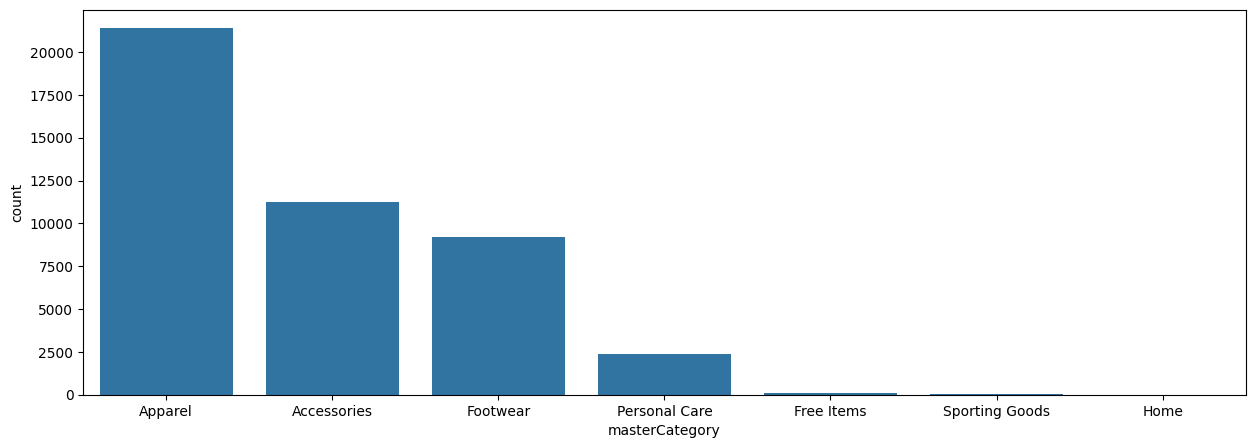

In [11]:
fig = plt.figure(figsize=(15,5))
sns.countplot(x='masterCategory',data=df)

## Versão do Tensorflow e Tensorflow-hub

As versões Tensorflow 2.13.0 e Tensorflow-hub 0.14.0 foram utilizadas para rodar o modelo.

In [ ]:
!pip install tensorflow==2.13.0 tensorflow-hub==0.14.0

import keras
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

## Upload do modelo

In [13]:
import tensorflow_hub as hub

# 'https://tfhub.dev/google/bit/m-r50x3/1'
MODULE_HANDLE = 'https://tfhub.dev/google/bit/m-r50x1/1'
module = hub.load(MODULE_HANDLE)
print("Módulo carregado com sucesso:", module)

Módulo carregado com sucesso: <tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7c1ad7b3c850>


In [14]:
IMAGE_SIZE = (160, 160)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))
BATCH_SIZE = 32
N_FEATURES = 256

Using https://tfhub.dev/google/bit/m-r50x1/1 with input size (160, 160)


In [15]:
data_dir = '/content/Fashion_data/categories'

## Tratamento das imagens para o modelo

Dimensionamento dos valores de pixel, divisão dos dados em conjuntos de treinamento e validação e, opcionalmente, aplicação de aumentos às imagens de treinamento. Os objetos train_generator e valid_generator são iteradores que fornecerão lotes de imagens para seu modelo durante o treinamento e a avaliação, respectivamente.

In [16]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, **dataflow_kwargs)

do_data_augmentation = False
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 8886 images belonging to 7 classes.
Found 35555 images belonging to 7 classes.


## Configuração do modelo de deep learning

Configuração do modelo de Deep Learning para classificação de imagens usando um modelo pré-treinado [BiT collection]('https://tfhub.dev/google/bit/m-r50x1/1'). Personalização do modelo com adição das camadas dropout e densas, aplicada a regularização para evitar overfitting e exibe um resumo da arquitetura com model.summary().

In [17]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(MODULE_HANDLE, trainable=False),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(N_FEATURES,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/bit/m-r50x1/1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              23500352  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 24026695 (91.65 MB)
Trainable params: 526343 (2.01 MB)
Non-trainable params: 23500352 (89.65 MB)
__________________

## Definição do optmizer e perda

Configuração dos componentes principais para treinar o modelo. Definição de como o modelo aprenderá (otimizador), o que ele pretende minimizar (função de perda) e como seu desempenho será avaliado (métricas). O cronograma de taxa de aprendizado é adicionado para ajustar dinamicamente a taxa de aprendizado durante o treinamento para melhor convergência.

In [18]:
lr = 0.01 * BATCH_SIZE / 512
SCHEDULE_LENGTH = 100
SCHEDULE_BOUNDARIES = [200]

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES,
                                                                   values=[lr, lr*0.1])
optimizer = tf.keras.optimizers.AdamW(learning_rate=3e-4, weight_decay=1e-4)

loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

## Variável checkpoint

A variável checkpoint irá salvar o melhor modelo em best_model.keras com seu mair valor de treinamento.

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [21]:
checkpoint = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_acc',
    save_best_only=True,
    mode='max',
    verbose=1
)


## Treinamento do modelo deep learning

Treinamento do modelo para duas épocas usando os dados de treinamento do train_generator, que será avaliado seu desempenho após cada época com os dados de validação do valid_generator. Os parâmetros steps_per_epoch e validation_steps controlam quantos lotes são usados ​​para treinamento e validação dentro de cada época, respectivamente. O histórico de treinamento (métricas) é salvo na variável history.

In [22]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
history = model.fit(
    train_generator,
    epochs=2, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    callbacks=[checkpoint],
    validation_steps=validation_steps).history

Epoch 1/2
1111/1111 [==============================] - ETA: 0s - loss: 0.3628 - accuracy: 0.9686

1111/1111 [==============================] - 4263s 4s/step - loss: 0.3628 - accuracy: 0.9686 - val_loss: 0.2907 - val_accuracy: 0.9884
Epoch 2/2
1111/1111 [==============================] - ETA: 0s - loss: 0.2554 - accuracy: 0.9812

1111/1111 [==============================] - 4189s 4s/step - loss: 0.2554 - accuracy: 0.9812 - val_loss: 0.2650 - val_accuracy: 0.9865


## Gráfico do período de aprendizado do modelo

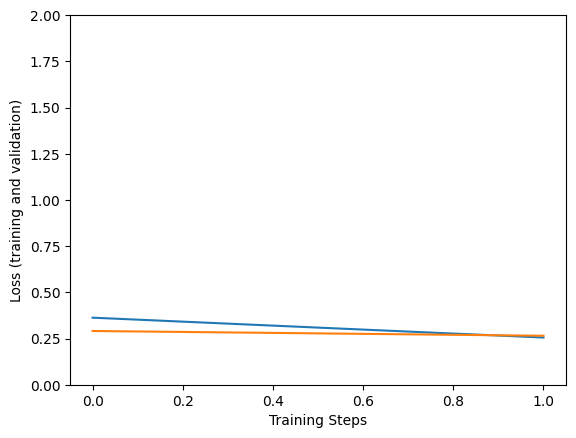

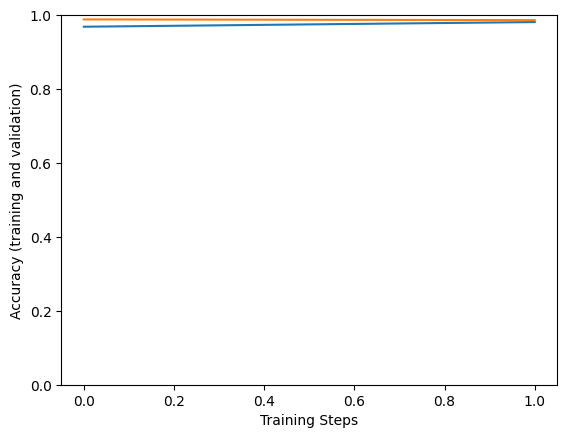

In [23]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(history["loss"])
plt.plot(history["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(history["accuracy"])
plt.plot(history["val_accuracy"])

## Armazenamento do modelo e extrator no google drive

Modelo treinado e seu extrator de recursos armazenados no Google Drive para uso futuro.

In [24]:
if not os.path.exists('/content/gdrive/MyDrive/ImgSim/'):
    os.mkdir('/content/gdrive/MyDrive/ImgSim/')

feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-3].output)
feature_extractor.save('/content/gdrive/MyDrive/ImgSim/bit_feature_extractor', save_format='tf')

saved_model_path = '/content/gdrive/MyDrive/ImgSim/bit_model'
tf.saved_model.save(model, saved_model_path)

## Vetorização das imagens

O vetor de características de cada imagem será salvo como uma matriz em um diretório. Após o processamento, salvaremos esses embeddings para uso posterior.

In [25]:
import tensorflow as tf
from pathlib import Path
import numpy as np
import os
from tqdm import tqdm
tqdm.pandas()

In [26]:
img_paths = []
for path in Path('/content/Fashion_data/categories').rglob('*.jpg'):
  img_paths.append(path)
np.random.shuffle(img_paths)

In [31]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img, channels=3)
  img = tf.image.resize_with_pad(img, 160, 160)
  img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  return img

In [32]:
TRANSFER_LEARNING_FLAG = 1
if TRANSFER_LEARNING_FLAG:
  module = tf.keras.models.load_model('/content/gdrive/MyDrive/ImgSim/bit_feature_extractor')
else:
  module_handle = "https://tfhub.dev/google/bit/m-r50x1/1/ilsvrc2012_classification/1"
  module = hub.load(module_handle)

In [33]:
imgvec_path = '/content/img_vectors/'
Path(imgvec_path).mkdir(parents=True, exist_ok=True)

In [34]:
for filename in tqdm(img_paths[:5000]):
    img = load_img(str(filename))
    features = module(img)
    feature_set = np.squeeze(features)
    outfile_name = os.path.basename(filename).split('.')[0] + ".npz"
    out_path_file = os.path.join(imgvec_path, outfile_name)
    np.savetxt(out_path_file, feature_set, delimiter=',')

100%|██████████| 5000/5000 [17:17<00:00,  4.82it/s]


## Metadados e Indexação

Será atribuido um id exclusivo a cada imagem e será criado dicionários para localizar informações dessa imagem: 1) Id da imagem para o dicionário de nome da imagem, 2) Id da imagem para o dicionário de vetor de recurso da imagem e 3) (opcional) Id da imagem para o dicionário de id do produto de metadados. Também criaremos um id da imagem para a indexação do vetor de recurso da imagem. Então, salvaremos esses dicionários e objetos de índice para uso posterior.

In [35]:
import pandas as pd
import glob
import os
import numpy as np
from tqdm import tqdm
tqdm.pandas()
!pip install -q annoy
import json
from annoy import AnnoyIndex
from scipy import spatial
import pickle
from IPython.display import Image as dispImage

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 33.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


## Imagem para teste do dataset

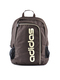

In [37]:
test_img = '/content/Fashion_data/categories/Accessories/15922.jpg'
dispImage(test_img)

In [42]:
styles = pd.read_csv('/content/styles.csv', on_bad_lines='skip')
styles['id'] = styles['id'].astype('str')
root_path = '/content'
styles.to_csv(root_path + '/styles.csv', index=False)

## Verifica se o produto está no dataset

A função match_id recebe um nome de arquivo (fname) como entrada. Ela procura um produto no DataFrame styles cujo ID corresponde ao nome do arquivo. Se encontrar uma correspondência, ela retorna o índice desse produto no DataFrame. Esse índice pode então ser usado para acessar outras informações sobre o produto, como sua categoria, descrição, etc., do DataFrame.

In [43]:
def match_id(fname):
  return styles.index[styles.id==fname].values[0]

## Configuração das estruturas de dados necessárias para um sistema de busca de similaridade de imagem usando a biblioteca Annoy.

Estruturas de dados: Três dicionários são criados para armazenar o mapeamento entre índices de arquivo de imagem, nomes de arquivo, vetores de recursos e (opcionalmente) IDs de produto. Esses dicionários serão preenchidos posteriormente para recuperar informações de imagem de forma eficiente.

Configuração Annoy: Parâmetros-chave para o índice Annoy são definidos, incluindo a dimensionalidade dos vetores de recursos (dims), o número desejado de vizinhos mais próximos (n_nearest_neighbors) e o número de árvores no índice (árvores). Esses parâmetros influenciam a precisão e o desempenho da busca de similaridade.

Leitura de arquivo: O código identifica e lê os caminhos de todos os arquivos que armazenam vetores de recursos de imagem, que serão usados ​​para construir o índice Annoy.

Inicialização do índice: Um índice Annoy é inicializado com a dimensionalidade especificada e a métrica de distância ('angular'), preparando-o para armazenar e buscar vetores de imagem semelhantes.

In [44]:
file_index_to_file_name = {}
file_index_to_file_vector = {}
file_index_to_product_id = {}

dims = 256
n_nearest_neighbors = 20
trees = 10000

allfiles = glob.glob('/content/img_vectors/*.npz')

t = AnnoyIndex(dims, metric='angular')

## Preparação dos dados para pesquisa de similaridade de imagem

Carregamento dos vetores de recursos de arquivos, criação dos dicionários para mapear entre IDs de imagem, nomes, vetores e IDs de produtos, e, o mais importante, criação o índice Annoy para pesquisas rápidas de similaridade.

In [45]:
for findex, fname in tqdm(enumerate(allfiles)):
  file_vector = np.loadtxt(fname)
  file_name = os.path.basename(fname).split('.')[0]
  file_index_to_file_name[findex] = file_name
  file_index_to_file_vector[findex] = file_vector
  try:
    file_index_to_product_id[findex] = match_id(file_name)
  except IndexError:
    pass
  t.add_item(findex, file_vector)

5000it [00:22, 220.85it/s]


## Contrução do indexes com Annoy

In [46]:
t.build(trees)
t.save('t.ann')

True

In [47]:
file_path = '/content/gdrive/MyDrive/ImgSim/'

## Criação do sistema de mapeamento de imagens por similaridade

In [48]:
t.save(file_path+'indexer.ann')
pickle.dump(file_index_to_file_name, open(file_path+"file_index_to_file_name.p", "wb"))
pickle.dump(file_index_to_file_vector, open(file_path+"file_index_to_file_vector.p", "wb"))
pickle.dump(file_index_to_product_id, open(file_path+"file_index_to_product_id.p", "wb"))

## Local de teste

Será carregada uma imagem aleatória e será encontrada as K imagens mais semelhantes.

In [49]:
from PIL import Image
import matplotlib.image as mpimg

## Carregamento da imagem aleatória para teste

a imagem de teste para baixar da web será convertida em um vetor de características usando um codificador de imagem e redimensionará a imagem para exibição, preparando-a para a pesquisa de similaridade de imagens.

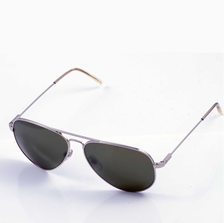

In [56]:
img_addr = 'https://images.tcdn.com.br/img/img_prod/654644/sunglass_electric_av1_large_platinum_m_grey_silver_chrome_213_1_c6db098c41ea6d913fa31a6d9e51caee.jpg'

!wget -q -O img.jpg $img_addr
test_img = 'img.jpg'
topK = 4

test_vec = np.squeeze(module(load_img(test_img)))

basewidth = 224
img = Image.open(test_img)
wpercent = (basewidth/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
img = img.resize((basewidth,hsize), Image.Resampling.LANCZOS)
img

## Resultado

Criação de um dicionário da pesquisa de imagem, será encontrada as imagens semelhantes usando o índice Annoy e, em seguida, serão exibidas essas imagens semelhantes junto com suas informações de produto em uma figura Matplotlib.

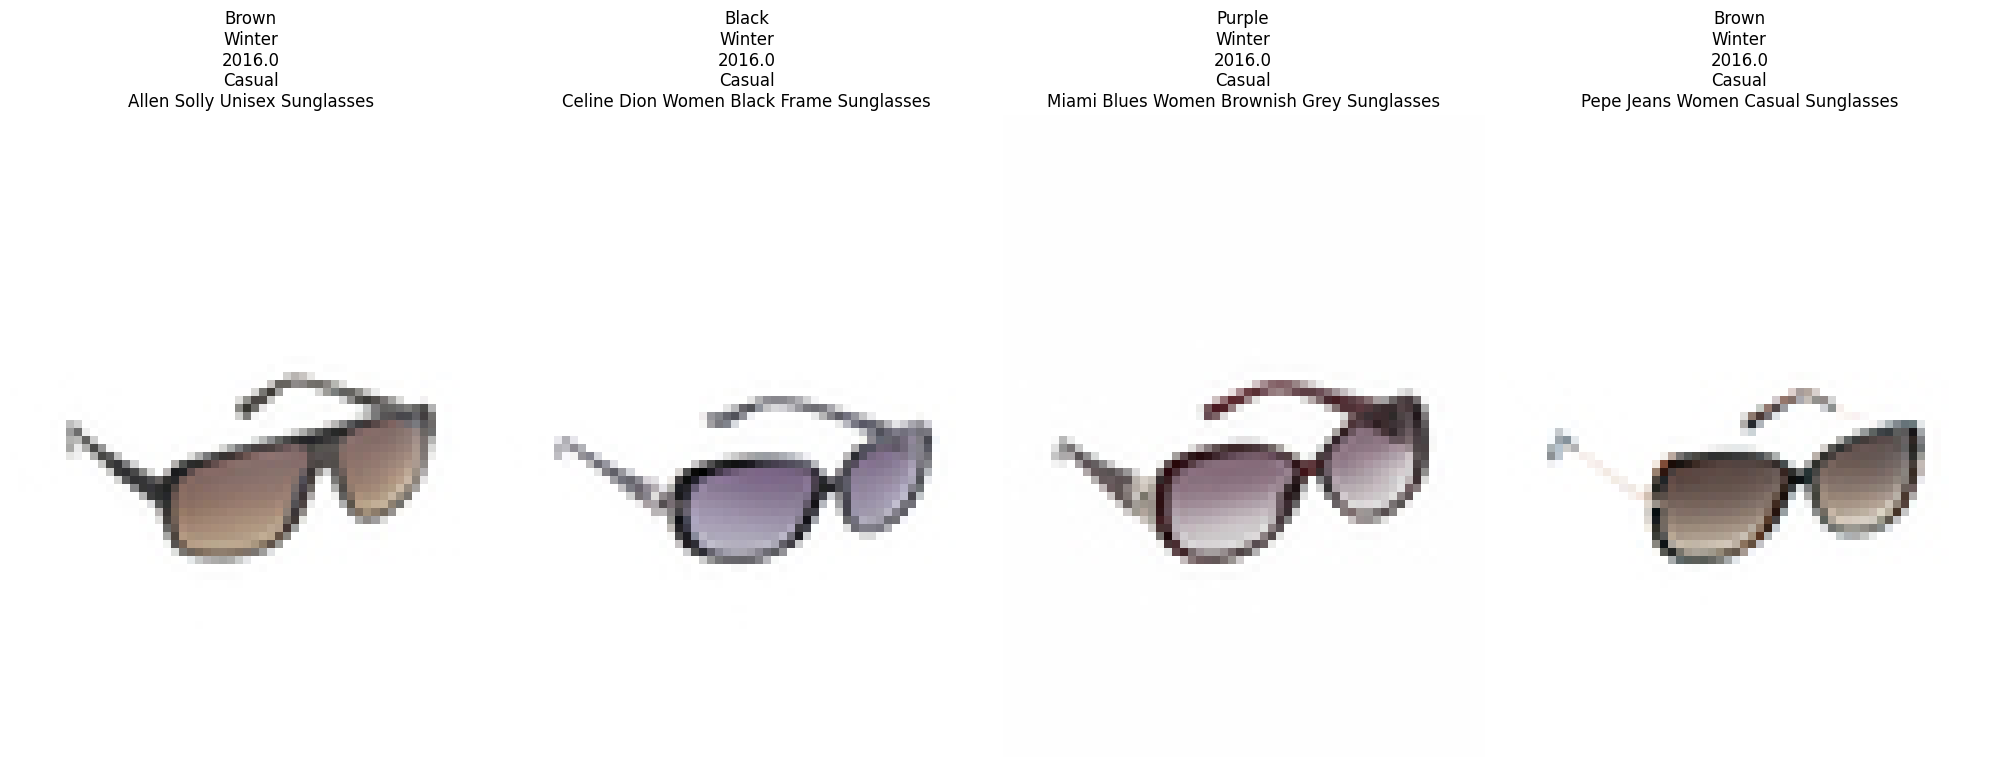

In [57]:
path_dict = {}
for path in Path('/content/Fashion_data/categories').rglob('*.jpg'):
  path_dict[path.name] = path

nns = t.get_nns_by_vector(test_vec, n=topK)
plt.figure(figsize=(20, 10))
for i in range(topK):
  x = file_index_to_file_name[nns[i]]
  x = path_dict[x+'.jpg']
  y = file_index_to_product_id[nns[i]]
  title = '\n'.join([str(j) for j in list(styles.loc[y].values[-5:])])
  plt.subplot(1, topK, i+1)
  plt.title(title)
  plt.imshow(mpimg.imread(x))
  plt.axis('off')
plt.tight_layout()

## Conclusão

Mesmo o modelo mais leve da BIT connnect treinado com apenas 2 épocas atingiu uma alta acurácia com 98.12%. Além disso, o indexador Annoy foi rápido e eficiente para recomendar os produtos com base no produto selecionado.